In [1]:
# !pip install tensorflow_text
# !pip install transformers
# !pip install keras-tuner
# !pip install pydot

In [2]:
## Usual Imports

## Math and Arrays
import numpy as np
# import pandas as pd
from statistics import mean

# OS and Utilities
import sys
import datetime

## File and String Handling
import re
import json
import string

# Visualizations
import matplotlib.pyplot as plt

# BERT
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

# Tensorflow 2 core - preprocessing no longer needed as we are using BERT
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

#Import Tuining toolkit for automatic Hyperparameter search
import kerastuner as kt

# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# Add local path to .py modules and add utilities
sys.path.insert(0, '../python')

import debug

from jbyrne_utils import load_data
# from jbyrne_utils import tokenize_sentences
# from jbyrne_utils import embed_matrix
# from jbyrne_utils import run_model

# Set message level

# debug.off()
# debug.on()
debug.show_detail()


*************** DEBUG DETAILS TURNED ON *****************


In [3]:
### Parameters for the base model

# maximum number of tokens to look at.
max_len = 100



In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6637314990152752645,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6702128192
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6343277627699004557
 physical_device_desc: "device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:21:00.0, compute capability: 7.5"]

## Step 1:  Load the ClaimBuster datafile

In [5]:
d = load_data("../data/3xNCS.json")

# Randomize the order as the data is sorted by class
np.random.seed(42)
np.random.shuffle(d)


Loaded 11056 data records.


In [6]:
## View an random example entry
d[512]

{'sentence_id': 9703,
 'label': 1,
 'text': 'President Obama was right, he said that that was outrageous to have deficits as high as half a trillion dollars under the Bush years.'}

## Step 2:  Tokenize the sentences using BERT tokenizer



In [7]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [8]:
input_sentences=[]
input_ids=[]
attention_masks=[]  # used so BERT can discount padding in the fixed-length token list

# avoid big output for just this cell
debug.on()

for sentence in [ i["text"] for i in d ]:
    input_sentences.append(sentence)
    bert_input = bert_tokenizer.encode_plus(sentence,
                                            add_special_tokens=True,  # adds the CLS etc.
                                            max_length=max_len,
                                            truncation=True,          # truncate sentences over max_len
                                            padding = 'max_length',   # add padding ids (0) up to max_len
                                            return_attention_mask=True)
    input_ids.append(bert_input['input_ids'])
    attention_masks.append(bert_input['attention_mask'])
    debug.detail(bert_input)

    
input_ids = np.asarray(input_ids)
attention_masks = np.asarray(attention_masks)
input_sentences = np.asarray(input_sentences)
labels = np.array( [i["label"] for i in d] )

# check lengths of arrays
debug.msg(len(input_ids), len(attention_masks), len(labels), len(input_sentences))

# reset to previous debugging level
debug.last()

****************** DEBUG TURNED ON **********************
11056 11056 11056 11056
*************** DEBUG DETAILS TURNED ON *****************


In [9]:
## Verify the tokenization of the previous sample sentence

debug.msg(d[512]["text"])
debug.msg(input_ids[512])
bert_tokenizer.convert_ids_to_tokens(input_ids[512])



President Obama was right, he said that that was outrageous to have deficits as high as half a trillion dollars under the Bush years.
[  101  2343  8112  2001  2157  1010  2002  2056  2008  2008  2001 25506
  2000  2031 15074  2015  2004  2152  2004  2431  1037 23458  6363  2104
  1996  5747  2086  1012   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


['[CLS]',
 'president',
 'obama',
 'was',
 'right',
 ',',
 'he',
 'said',
 'that',
 'that',
 'was',
 'outrageous',
 'to',
 'have',
 'deficit',
 '##s',
 'as',
 'high',
 'as',
 'half',
 'a',
 'trillion',
 'dollars',
 'under',
 'the',
 'bush',
 'years',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Step 3a: Split into training, validation and test datasets

In [10]:
train_len = int(0.8 * len(d))
val_len = int(0.2 * len(d))

train_ids, val_ids             = np.split(input_ids, [train_len])
train_attn, val_attn           = np.split(attention_masks, [train_len])
train_sentences, val_sentences = np.split(input_sentences, [train_len])
train_labels, val_labels       = np.split(labels, [train_len])

debug.msg(f"proportion of checkable claims in training data  : {np.count_nonzero(train_labels == 1)/len(train_labels):.4f}")
debug.msg(f"proportion of checkable claims in validation data: {np.count_nonzero(val_labels == 1)/len(val_labels):.4f}")

debug.detail(len(train_ids), len(train_attn), len(train_sentences), len(train_labels))
debug.detail(len(val_ids), len(val_attn), len(val_sentences), len(val_labels))

proportion of checkable claims in training data  : 0.2495
proportion of checkable claims in validation data: 0.2518
8844 8844 8844 8844
2212 2212 2212 2212


## Step 3b: Even out the checkable and non-checkable classes.

The intention here is to equalize the number of checkable and non-checkable sentences. In the raw dataset, approximately 25% of the statements are labelled as checkable claims.

As we are looking at detailed text and whether it includes a checkable claim, there is no reliable equivalent of the data enhancement techniques that exist for image or sound data.  

We are presented with the choice, therefore, of removing $\frac{2}{3}$ of the non-checkable claims - as the source dataset has provided, or adding two copies of each checkable claim to reach approximately a 1:1 ratio of classes in the training data. The second method has proved especially successful in the CNN examples, so we will do the same for the BERT case.


In [11]:
## Ideally we could rerandomize the training set, but
## for the moment, we will try just adding copies of 
## the positive records to the end.

pos_train_ids = train_ids[ train_labels == 1 ]
pos_train_attn = train_attn[ train_labels == 1 ]
pos_train_sentences = train_sentences[ train_labels == 1 ]
pos_train_labels = train_labels[ train_labels == 1 ]  # kinda redundant, but an easy way to get the right length.

print(train_ids.shape)
print(train_attn.shape)
print(train_sentences.shape)
print(train_labels.shape)


## concatenate two copies of the positive cases to each of the training datasets

train_ids       = np.concatenate( (train_ids, pos_train_ids, pos_train_ids) )
train_attn      = np.concatenate( (train_attn, pos_train_attn, pos_train_attn) )
train_sentences = np.concatenate( (train_sentences, pos_train_sentences, pos_train_sentences) )
train_labels    = np.concatenate( (train_labels, pos_train_labels, pos_train_labels) )

(8844, 100)
(8844, 100)
(8844,)
(8844,)


In [17]:
print(f"train_ids.shape:       {train_ids.shape}")
print(f"train_attn.shape:      {train_attn.shape}")
print(f"train_sentences.shape: {train_sentences.shape}")
print(f"train_labels.shape:    {train_labels.shape}\n\n")

print(f"val_ids.shape:         {val_ids.shape}")
print(f"val_attn.shape:        {val_attn.shape}")
print(f"val_sentences.shape:   {val_sentences.shape}")
print(f"val_labels.shape:      {val_labels.shape}")

train_ids.shape:       (13258, 100)
train_attn.shape:      (13258, 100)
train_sentences.shape: (13258,)
train_labels.shape:    (13258,)


val_ids.shape:         (2212, 100)
val_attn.shape:        (2212, 100)
val_sentences.shape:   (2212,)
val_labels.shape:      (2212,)


## Step 4: Set up the Bert model

Claim detection is a sentence classification task, so for the first runs, I will base this on the `TFBertForSequenceClassification` class from the huggungface Tensorflow implementation of Bert. 

To keep it simple, the model build is packaged into a build_bert_model function that returns a compiled model
with the search space already added.



In [29]:
# Experiment on building the model



################################################
####  DEFINE THE HYPERPARAMETER SEARCH SPACE ###
################################################
bert_trainable = True

optimizer      = keras.optimizers.Adam( learning_rate = 5e-06, epsilon = 5e-05 )
                                                  
loss           = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric         = keras.metrics.SparseCategoricalAccuracy('accuracy')


#################################
####  CREATE THE CUSTOM MODEL ###
#################################



# Define the input layer: the tokens are denoted by an integer ID. Max number of tokens = max_len
# The attention mask is similarly an array of max_len integers, but will be only 1 or 0.
# the input layer concatenates the IDs with the attention_masks, the idea is for Bert to ignore
# the padding in the input by using the attention_masks.

input_ids       = keras.Input( shape=(max_len, ), dtype='int32', name="InputIds")
attention_masks = keras.Input( shape=(max_len, ), dtype='int32', name="AttnMasks")

# create the bert model using the uncased base (smaller) model
output = TFBertModel.from_pretrained('bert-base-uncased', trainable=bert_trainable)([input_ids,attention_masks])

# print("last_hidden_state is a", type(output.last_hidden_state))

# connect the dense layers we want to add to the output of the
# bert model

debug.detail(f"output[0] output: {output[0].shape}")
debug.detail(f"output[1] output: {output[1].shape}")

output = output[0]
output = keras.layers.Flatten()(output)

# output = keras.layers.Dense(300, activation='relu')(output)
# output = keras.layers.Dropout(0.2)(output)
output = keras.layers.Dense(1, activation='softmax')(output)
debug.detail(f"dense output: {output.shape}")

model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

print('\nBert Model',model.summary())

############################################
####  COMPILE THE MODEL WITH THE CHOICES ###
############################################
model.compile(loss=loss, optimizer=optimizer, metrics=[metric] )



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


output[0] output: (None, 100, 768)
output[1] output: (None, 768)
dense output: (None, 1)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputIds (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
AttnMasks (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 109482240   InputIds[0][0]                   
                                                                 AttnMasks[0][0]                  
__________________________________________________________________________________________________
fla

In [30]:
print(train_ids.shape)
print(train_attn.shape)
print(train_labels.shape)

print(val_ids.shape)
print(val_attn.shape)
print(val_labels.shape)

print(output.shape)

(13258, 100)
(13258, 100)
(13258,)
(2212, 100)
(2212, 100)
(2212,)
(None, 1)


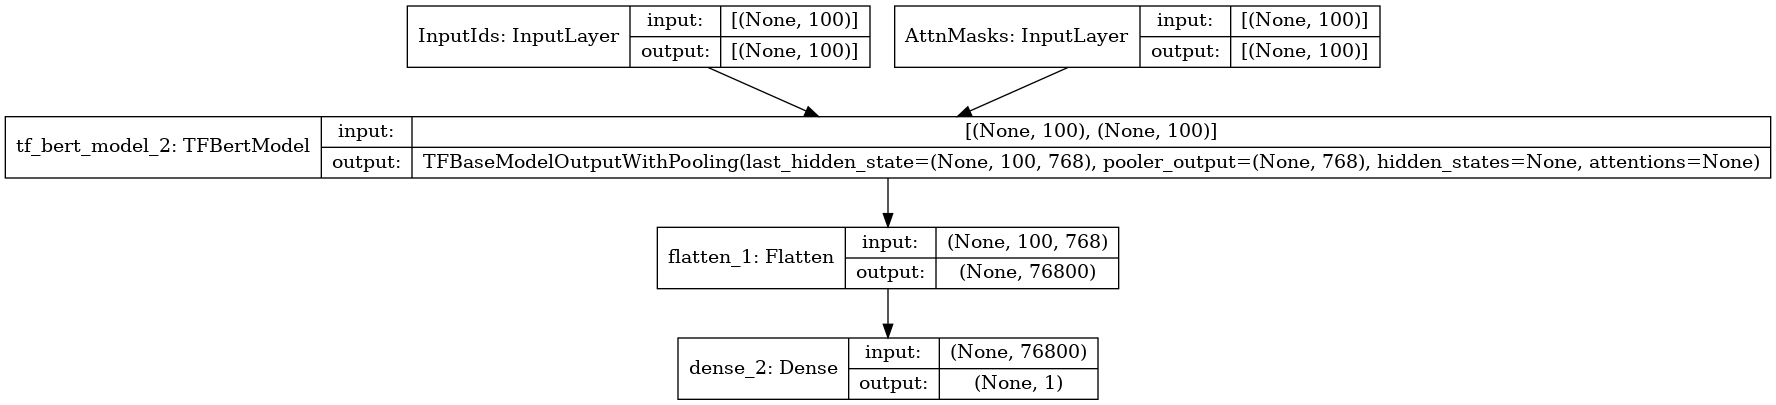

In [31]:
keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

In [1]:
history=bert_model.fit([train_ids,train_attn],
                       train_labels,
                       batch_size=32,
                       epochs=5,
                       validation_data=([val_ids,val_attn],val_labels) 
                      )

NameError: name 'bert_model' is not defined

## Step 5: Set up the Keras Tuner

From https://github.com/keras-team/keras-tuner/README.md:

***
Next, instantiate a tuner. You should specify the model-building function, the name of the objective to optimize (whether to minimize or maximize is automatically inferred for built-in metrics), the total number of trials (max_trials) to test, and the number of models that should be built and fit for each trial (executions_per_trial).

Available tuners are `RandomSearch` and `Hyperband`.

Note: the purpose of having multiple executions per trial is to reduce results variance and therefore be able to more accurately assess the performance of a model. If you want to get results faster, you could set executions_per_trial=1 (single round of training for each model configuration).
***

More reading shows that there are additional tuners in `kt.tuners` like `kt.tuners.BayesianOptimization`.

In [ ]:
# Create the tuner object
#
# There are two options, RandomSearch and Hyperband.

runtag = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_dir='./tb_bert_tuner/'+ runtag

tuner = kt.tuners.BayesianOptimization(
    build_bert_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=5,
    directory=log_dir,
    project_name='BertTunerRandom')


## Step 6: Create Callbacks

Adding a new callback here, keras.callbacks.EarlyStopping(). This stops after the monitored metric (usually loss) stops improving.  The $patience$ term is the number of epochs that will be executed without improvement before stopping to allow for possible oscilation.

In [ ]:
runtag = datetime.datetime.now().strftime("%y%m%d-%H%M%S")

log_dir='./tb_bert/'+ runtag

model_save_path='../models/bert_keras_tuner/' + runtag

## Create Callback list
callbacks = [keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                             save_weights_only=False,
                                             monitor='val_loss',
                                             mode='min',
                                             save_best_only=True),
             keras.callbacks.EarlyStopping(monitor='loss', patience=3),
             keras.callbacks.TensorBoard(log_dir=log_dir)]


## Step 7: Run the Optimizer

Tuner.search() has the same signature (parameters) as keras.Model.fit().

In [ ]:
tuner.search([train_ids,train_attn],
             train_labels,
             batch_size=24,
             epochs=10,
             validation_data=([val_ids,val_attn],val_labels),
             callbacks=callbacks)

In [ ]:
best_model = tuner.get_best_models(1)[0]

In [ ]:
best_hyperameters = tuner.get_Best_hyperparameters(1)[0]

In [ ]:
tuner.results_summary()

## References used
BERT Text Classification using Keras https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d#2f06

Keras Tuner blog: https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html

Keras Tuner Git:  https://github.com/keras-team/keras-tuner

Huggingface with custom dense layers: https://www.kaggle.com/dhruv1234/huggingface-tfbertmodel

http://jalammar.github.io/illustrated-bert/

@misc{omalley2019kerastuner,
	title        = {Keras {Tuner}},
	author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others},
	year         = 2019,
	howpublished = {\url{https://github.com/keras-team/keras-tuner}}
}